In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import numpy as np

from optimal_transport import OTPlanSampler

from IPython.display import display, HTML

from matplotlib import pyplot as plt
from matplotlib import animation

# vector fields and induced distributions

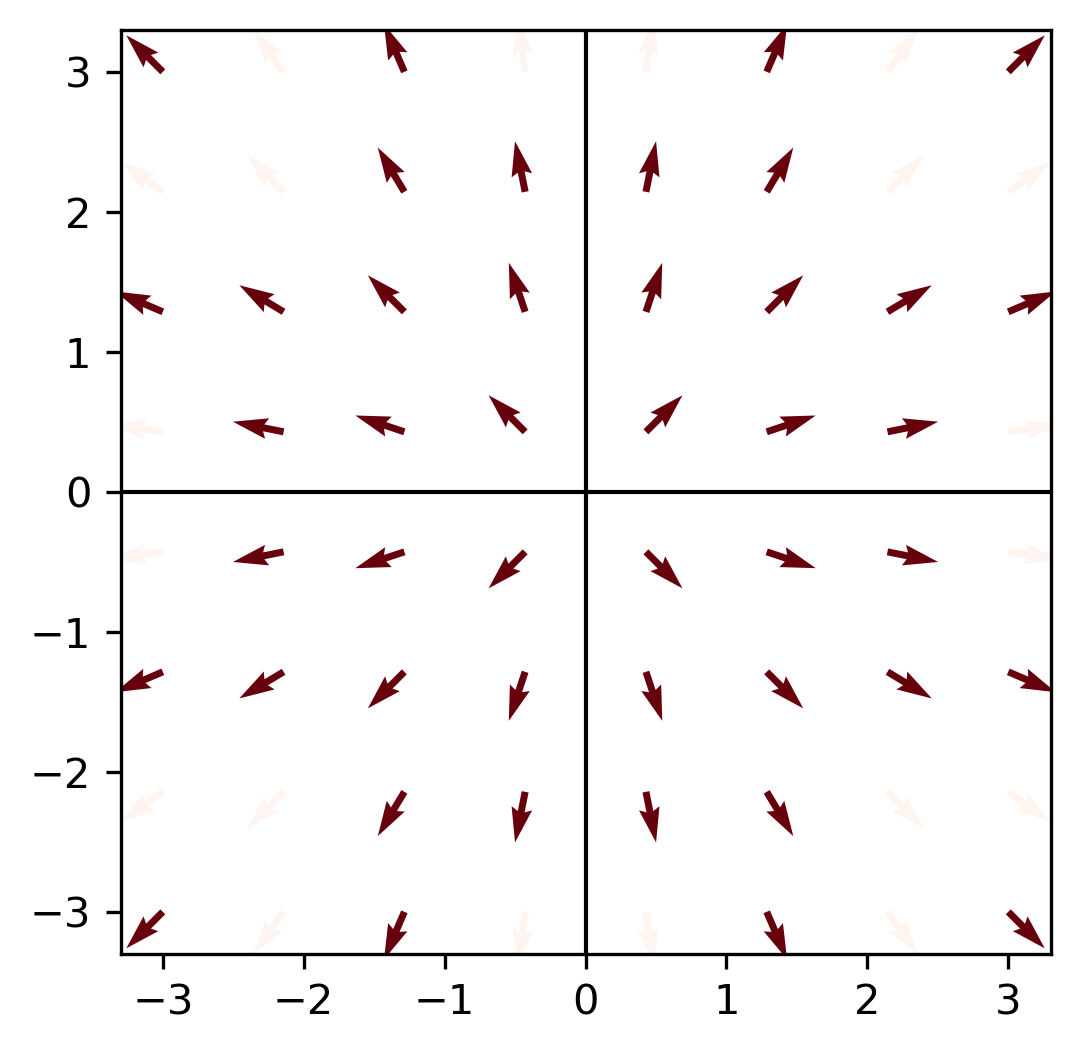

In [54]:
# use matlotlib rc params to set the figure dpi
plt.rcParams['figure.dpi'] = 300

# use matplotlib rc params to set figure width and height
plt.rcParams['figure.figsize'] = (4,4)

# visualize our vector field
def make_vector_field_plot(u, t: float, xlim, ylim, n_points=15, return_grid=False):
    # plot p_0 and p_1 densities on a mesh grid
    x = torch.linspace(*xlim, n_points)
    y = torch.linspace(*ylim, n_points)
    X, Y = torch.meshgrid(x, y)
    grid = torch.stack((X.flatten(), Y.flatten()), dim=-1)
    # vecs = u(torch.cat((grid, t*torch.ones(grid.shape[0], 1)), dim=-1)).reshape(n_points,n_points,2)
    vecs = u(grid, t).reshape(n_points,n_points,2)
    
    # convert X, Y, vecs to numpy arrays
    X = X.detach().numpy()
    Y = Y.detach().numpy()
    vecs = vecs.detach().numpy()
    C = np.linalg.norm(vecs, axis=-1)

    if return_grid:
        return X, Y, vecs, C

    plt.quiver(X, Y, vecs[:,:,0], vecs[:,:,1], C, cmap='Reds')

# define our simple vector field
def u(x, t=None):
    return x / torch.norm(x, dim=-1, keepdim=True)




make_vector_field_plot(u, 0, (-3,3), (-3,3), n_points=8)
xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', linewidth=1)
plt.vlines(x=0, ymin=ylim[0], ymax=ylim[1], color='black', linewidth=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# visualize trajectories in a vector field

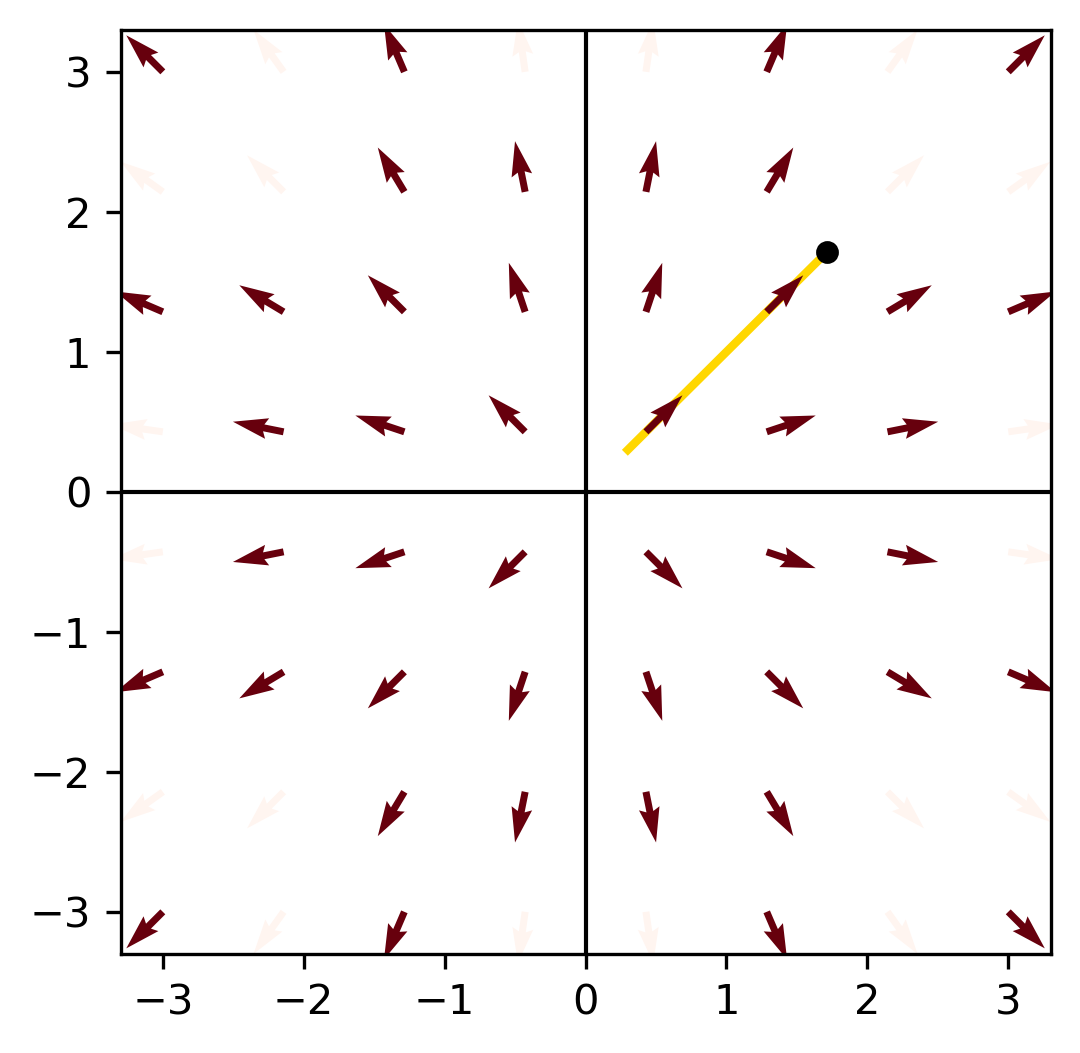

In [67]:
# create a function for integrating the vector field using Euler's method
def integrate_u(x_0, u, n_steps=100, t_max=1):
    """Use Euler integration to integrate the time-varying vector field u from 0 to 1"""

    # x_0 is a tensor of shape (batch_size, 2) containing the initial positions
    # u is a time varying vector field (the trained neural network)
    # n_steps is the number of integration steps to run
    batch_size = x_0.shape[0]
    t = torch.linspace(0, t_max, n_steps)
    dt = t[1] - t[0]
    x_t = torch.zeros(*x_0.shape, n_steps, dtype=x_0.dtype) # state, has shape (batch_size, 2, n_steps)
    x_t[:,:,0] = x_0
    for step_idx in range(n_steps-1):
        current_state = x_t[:, :, step_idx]
        u_input = (current_state, t[step_idx])
        x_t[:, :, step_idx+1] = current_state + dt*u(*u_input)
    return t, x_t

def update_traj_frame(frame_idx, t, x_t, traj_lines, traj_scatter, xlim, ylim):
    """Update the trajectory animation"""
    for traj_idx in range(len(traj_lines)):
        traj_lines[traj_idx].set_data(x_t[traj_idx,0,:frame_idx], x_t[traj_idx,1,:frame_idx])

    traj_scatter.set_offsets(x_t[:,:,frame_idx])
    return traj_lines, traj_scatter

def animate_trajectory(t, x_t, xlim=(-3,3), ylim=(-3,3), interval=75, s=10, lw=1.0, traj_alpha=1.0, pos_alpha=1.0):


    t = t.detach().numpy()
    x_t = x_t.detach().numpy()
    plt.xlim(xlim)
    plt.ylim(ylim)

    n_trajectories = x_t.shape[0]   

    x_0 = x_t[:,:,0]


    # plot the trajectory and colect the line object
    traj_lines = []
    for traj_idx in range(x_t.shape[0]):
        traj_line = plt.plot(x_t[traj_idx,0,:], x_t[traj_idx,1,:], color='gold', linewidth=lw, zorder=0, alpha=traj_alpha)[0]
        traj_lines.append(traj_line)

    # scatter-plot intial positions
    current_pos_scatter = plt.scatter(x_0[:,0], x_0[:,1], color='black', s=s, zorder=1, alpha=pos_alpha)

    anim = animation.FuncAnimation(plt.gcf(), update_traj_frame, frames=x_t.shape[-1], interval=interval, fargs=(t, x_t, traj_lines, current_pos_scatter, xlim, ylim))
    return anim




# x_0 = torch.tensor([[0.5, 0.5]])
n_trajectories = 500
x_0 = torch.randn(n_trajectories,2)*0.5
x_0 = torch.tensor([[0.3, 0.3]])
t, x_t = integrate_u(x_0, u, n_steps=80, t_max=2.0)

xlim = (-3,3)
ylim = (-3,3)
make_vector_field_plot(u, 0, xlim, ylim, n_points=8)
xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', linewidth=1)
plt.vlines(x=0, ymin=ylim[0], ymax=ylim[1], color='black', linewidth=1)
plt.xlim(xlim)
plt.ylim(ylim)

anim = animate_trajectory(t, x_t, xlim=xlim, ylim=ylim, interval=50, s=20, lw=2, traj_alpha=1.0, pos_alpha=1.0)
HTML(anim.to_html5_video())
anim.save('presentation_figures/single_traj.mp4', dpi=300)

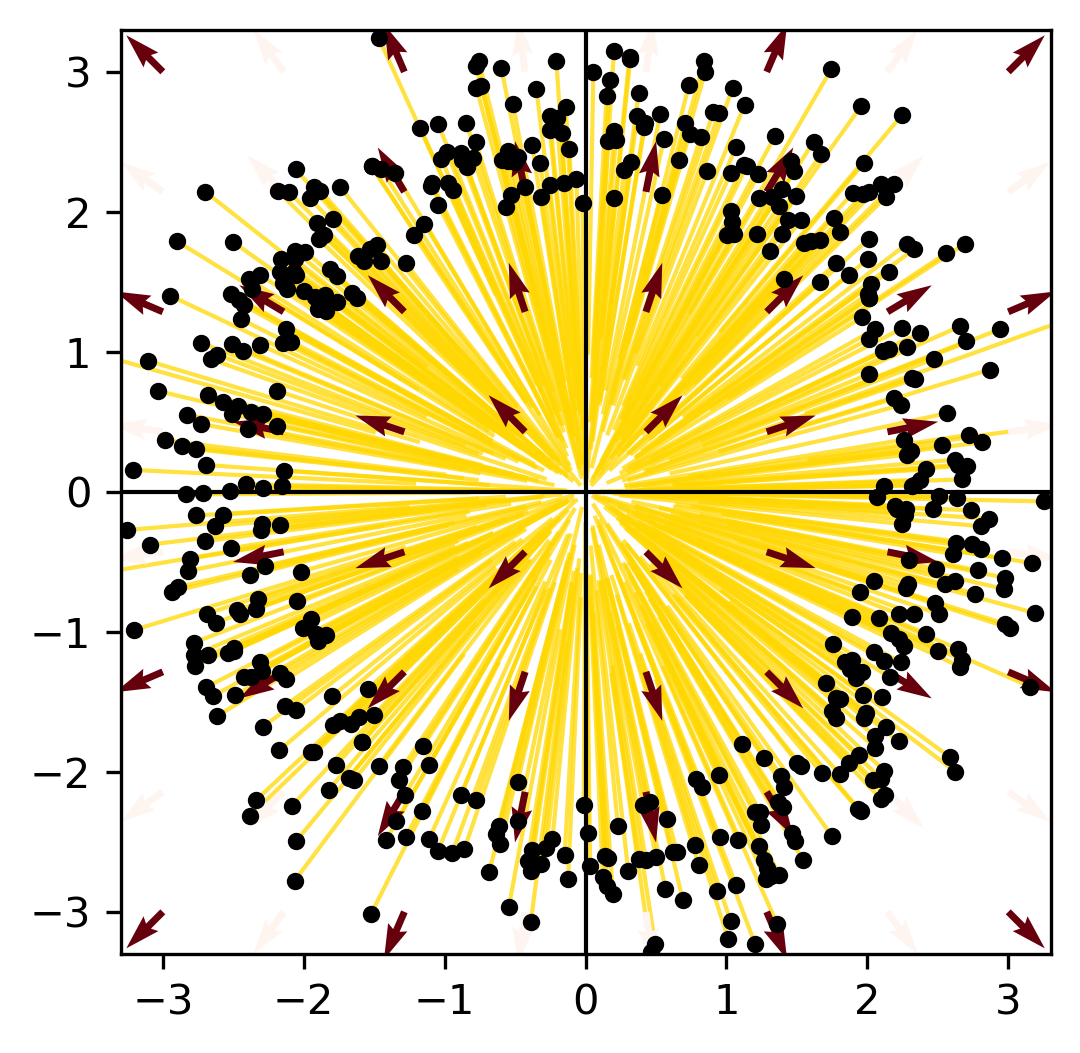

In [70]:
n_trajectories = 500
x_0 = torch.randn(n_trajectories,2)*0.5
t, x_t = integrate_u(x_0, u, n_steps=80, t_max=2.0)

xlim = (-3,3)
ylim = (-3,3)
make_vector_field_plot(u, 0, xlim, ylim, n_points=8)
xlim = plt.xlim()
ylim = plt.ylim()
plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', linewidth=1)
plt.vlines(x=0, ymin=ylim[0], ymax=ylim[1], color='black', linewidth=1)
plt.xlim(xlim)
plt.ylim(ylim)

anim = animate_trajectory(t, x_t, xlim=xlim, ylim=ylim, interval=50, s=10, lw=1, traj_alpha=0.75, pos_alpha=1.0)
# HTML(anim.to_html5_video())
anim.save('presentation_figures/many_traj.mp4', dpi=300)